In [2]:
import cv2
import time
from deepface import DeepFace

# Load the face cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml')
# Open the video file
cap = cv2.VideoCapture("videoreume.mov")
print(cap.isOpened())
frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Get the frame rate of the video
wait_time = int(1000 / frame_rate*2)  # Calculate the wait time for 1 second per frame

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames:", total_frames)

current_frame = 0
prev_time = time.time()
confidences = []

while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break

    current_time = time.time()
    elapsed_time = current_time - prev_time

    if elapsed_time >= 1.0:  # Process frame once per second
        prev_time = current_time

        # Perform emotion analysis on the frame
        #result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
        current_frame += 1

        #gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=7)
        
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame,"FACE",(int(x-.1*x),int(y-.1*y)),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
            face_region = frame[y:y + h, x:x + w]
            #roi=gray_frame[y:y + h, x:x + w]
            result = DeepFace.analyze(face_region, actions=['emotion'], enforce_detection=False)
        
            '''smile = smile_cascade.detectMultiScale(
            roi,
            scaleFactor= 1.5,
            minNeighbors=7,
            minSize=(25,25))
            print("---->",len(smile))'''
            cv2.putText(frame, f"Emotion: {result[0]['dominant_emotion']}",
                    (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_4)
        '''#cv2.putText(frame, f"Confidence: {result['emotion']['dominance']:.2f}",
                    (0, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_4)'''

        #Append the confidence value to the list
        confidences.append(result[0]['dominant_emotion'])

    #cv2.imshow('Frame1', frame)
    if cv2.waitKey(wait_time ) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

element_count={elem:confidences.count(elem) for elem in confidences}
top_elements=sorted(element_count.items(),key=lambda x:x[1],reverse=True)[:3]
i=1
for element,count in top_elements:
    print("emotion",i,":",element)
    i+=1
print(element_count)

True
Total frames: 2018
emotion 1 : neutral
emotion 2 : happy
emotion 3 : sad
{'neutral': 168, 'sad': 20, 'happy': 35, 'fear': 13, 'angry': 8, 'disgust': 1}


['neutral', 'sad', 'happy', 'fear', 'angry', 'disgust']


<BarContainer object of 6 artists>

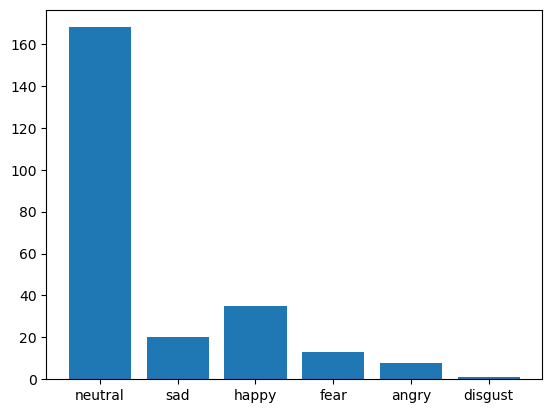

In [3]:
import matplotlib.pyplot as plt
emotions=list(element_count.keys())
counts=list(element_count.values())
print(emotions)
plt.bar(emotions,counts)

In [4]:
from imutils import face_utils
import math
import numpy as np
import dlib

KeyboardInterrupt: 

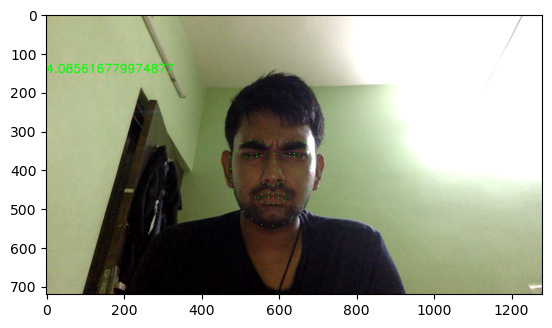

In [29]:
# Load pre-trained facial landmark detector from dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
def euclidean_distance(point1, point2):
    """
    Calculate the Euclidean distance between two points in 2D space.

    Parameters:
    - point1: Tuple (x1, y1) representing the coordinates of the first point.
    - point2: Tuple (x2, y2) representing the coordinates of the second point.

    Returns:
    - Distance: Euclidean distance between the two points.
    """
    x1, y1 = point1
    x2, y2 = point2

    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance


def extract_features(landmarks):
    # Extract relevant features from facial landmarks
    left_eye = landmarks[36:41]  # Left eye landmarks (indexes 36-41)
    right_eye = landmarks[42:47]  # Right eye landmarks (indexes 42-47)

    # Calculate eye openness (average distance between eye landmarks)
    left_eye_openness = calculate_openness(left_eye)
    right_eye_openness = calculate_openness(right_eye)
    eye_openness = (left_eye_openness + right_eye_openness) / 2.0

    # Calculate eyebrow position (vertical distance between eyebrow and eye)
    left_eyebrow = landmarks[17:22]  # Left eyebrow landmarks (indexes 17-21)
    right_eyebrow = landmarks[22:27]  # Right eyebrow landmarks (indexes 22-26)
    ratio,ratio1= calculate_eyebrow_position(landmarks)
    tilt_angle=calculate_face_tilt_angle(landmarks)
    # Calculate mouth curvature (distance between lip landmarks)
    mouth = landmarks[48:68]  # Mouth landmarks (indexes 48-67)
    mouth_curvature = calculate_mouth_curvature(mouth)

    return eye_openness, ratio,ratio1, mouth_curvature,tilt_angle

def calculate_face_tilt_angle(landmarks):
    left_eye_corner = landmarks[37]  # Left eye outer corner 
    right_eye_corner = landmarks[46]  # Right eye outer corner

    # Calculate the angle using arctangent (atan2) and convert radians to degrees
    angle_rad = math.atan2(right_eye_corner[1] - left_eye_corner[1], right_eye_corner[0] - left_eye_corner[0])
    tilt_angle = math.degrees(angle_rad)

    return tilt_angle

def calculate_openness(eye_landmarks):
    
    eye_width = eye_landmarks[-1][0] - eye_landmarks[0][0]
    eye_height = eye_landmarks[-2][1] - eye_landmarks[1][1]
    eye_openness = eye_height / eye_width  # Normalize if needed
    #print("--",eye_openness,"--")
    return eye_openness

def calculate_eyebrow_position(landmarks):
    
    left_eye_mid = ((landmarks[17][0] + landmarks[22][0]) // 2, (landmarks[17][1] + landmarks[22][1]) // 2)
    right_eye_mid = ((landmarks[22][0] + landmarks[26][0]) // 2, (landmarks[22][1] + landmarks[26][1]) // 2)
    
    eyebrow_position = abs(left_eye_mid[1] - right_eye_mid[1])  # Example calculation
    #left_ref_distance = np.linalg.norm(landmarks[18][0] - landmarks[22][0])
    #right_ref_distance = np.linalg.norm(landmarks[23][0] - landmarks[27][0])

    # Measure vertical displacement for left eyebrow
    #left_vertical_displacement = abs(landmarks[19][1] - landmarks[21][1])
    
    # Measure vertical displacement for right eyebrow
    #right_vertical_displacement = abs(landmarks[22][0] - landmarks[23][0])

    # Calculate Eyebrow Displacement Ratio (EDR)
    #left_EDR = (left_vertical_displacement / left_ref_distance) * 100
    #right_EDR = (right_vertical_displacement / right_ref_distance) * 100

    # Print EDR values
    #print(f" (EDR): {right_vertical_displacement:.2f}%")
    #print(f"Right Eyebrow Displacement Ratio (EDR): {right_EDR:.2f}%")
    #x,y=landmarks[36][0]
    
    diff_eye=(landmarks[45][0]-landmarks[36][0])
    diff_left=landmarks[20][1]-landmarks[39][1]
    diff_right=landmarks[23][1]-landmarks[42][1]
    ratio=abs(round(diff_left/diff_eye,2))
    ratio1=abs(round(diff_right/diff_eye,2))
    #print(diff_right,"////",diff_left,"///",diff_eye,"///",ratio,"///",ratio1)
    return ratio,ratio1
def calculate_mouth_curvature(mouth_landmarks):
    # Calculate mouth curvature based on the distance between lip landmarks
    # Example calculation: Euclidean distance between lip corners
    mouth_width = mouth_landmarks[-1][0] - mouth_landmarks[0][0]
    mouth_height = mouth_landmarks[-3][1] - mouth_landmarks[6][1]
    mouth_curvature = mouth_height / mouth_width  # Normalize if needed

    return mouth_curvature

def is_relaxed_face(frame_c,relaxed,er,fr,ta,ratio_of_left,ratio_of_right,mouth_curve,eye_open):
    # Load the image
    cap= cv2.VideoCapture(0)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Get the frame rate of the video
    wait_time = int(1000 / frame_rate*2)  
    prev_time = time.time()
    while cap.isOpened():
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        res,img=cap.read()
        if res==True:
        # Detect faces in the image
            faces = detector(img)
            frame_c[0]+=1
            for face in faces:
                landmarks = predictor(img, face)
                landmarks_np = [[p.x, p.y] for p in landmarks.parts()]
                display_landmarks(img, landmarks_np)
                    # Extract relevant features from landmarks
                eye_openness, ratio,ratio1, mouth_curvature,tilt_angle = extract_features(landmarks_np)
                ratio_of_left.append(ratio)
                ratio_of_right.append(ratio1)
                mouth_curve.append(mouth_curvature)
                eye_open.append(eye_openness)
                imag = cv2.flip(img, 1)
                if ratio>.35 or ratio1>.35:
                    er+=1
                if ratio<.25 or ratio1<.25:
                    fr+=1
                ta.append(tilt_angle)
                cv2.putText(imag,f"{tilt_angle}",
                        (0, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_4)
                    # Define conditions for a relaxed face based on extracted features
                    # Example condition: If eye openness is high, eyebrows are relaxed, and mouth curvature is neutral
                if eye_openness > 0.20 and (.25)<ratio<(.35) and (.25)<ratio1<(.35) : #and 0.2 < mouth_curvature < 0.8:
                    relaxed[0]+=1
                        #return True
                    cv2.putText(imag,"relaxed",
                        (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_4)
                else:
                    grey=cv2.cvtColor(imag,cv2.COLOR_BGR2RGB)
                    plt.imshow(grey)
                    plt.show
                    relaxed[1]+=1
                    cv2.putText(imag,"not_relaxed",
                            (0, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_4)
        
        #return False  # No relaxed face detected
                cv2.imshow("frame2",imag)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
    return frame_c,relaxed,er,fr,ta,ratio_of_left,ratio_of_right,mouth_curve,eye_open;

def display_landmarks(image, landmarks):
    """
    Display facial landmarks on the given image.

    Parameters:
    - image: Input image.
    - landmarks: List of landmark coordinates (x, y).
    
    """
    
    
    for (x, y) in landmarks:
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)  # Draw a green circle at each landmark position

    # Display the image with landmarks
    #plt.imshow(image,label="facial_image")
    #plt.show()
    
# Example usage:
image_path = 'path_to_your_image.jpg'
frame_c=[0]#total frame count
relaxed=[0,0]#total relaxed and non relaxed face count
fr,er=0,0#total number of frowned face vs enlarge face
ta=[]#tilte angle 
ratio_of_left,ratio_of_right,mouth_curve,eye_open=[],[],[],[]
frame_c,relaxed,er,fr,ta,ratio_of_left,ratio_of_right,mouth_curve,eye_open=is_relaxed_face(frame_c,relaxed,er,fr,ta,ratio_of_left,ratio_of_right,mouth_curve,eye_open)






In [32]:
print("Total frame count:",frame_c)
print("Total relaxed frame:",relaxed[0])
print("Total non-relexed frame:",relaxed[1])
print("the Deviation of angle:",np.std(ta))
print("avg ratio of dist. of left eye to eyebrows:",np.mean(ratio_of_left))
print("avg ratio of dist. of right eye to eyebrows:",np.mean(ratio_of_right))
print("avg of mouth_curvature:",np.mean(mouth_curve))


Total frame count: [152]
Total relaxed frame: 101
Total non-relexed frame: 51
the Deviation of angle: 4.961152092062072
avg ratio of dist. of left eye to eyebrows: 0.2766447368421053
avg ratio of dist. of right eye to eyebrows: 0.2861184210526315
avg of mouth_curvature: 0.009760499770233941


<function matplotlib.pyplot.show(close=None, block=None)>

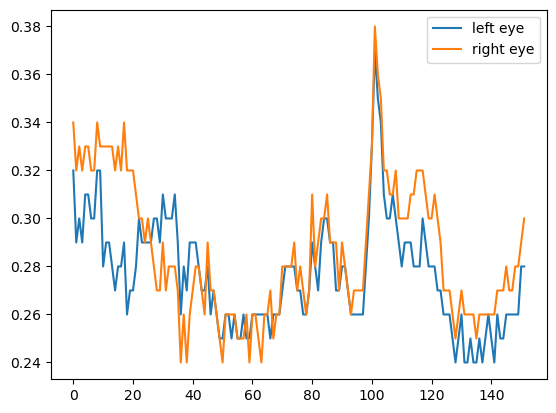

In [44]:
import matplotlib.pyplot as plt
plt.plot(ratio_of_left)
plt.plot(ratio_of_right)
plt.legend(["left eye","right eye"])
plt.show

Text(0.5, 1.0, 'title angle')

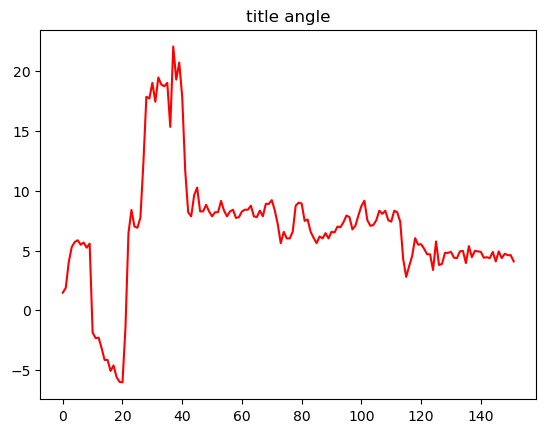

In [43]:
plt.plot(ta,color='red')
plt.title("title angle")

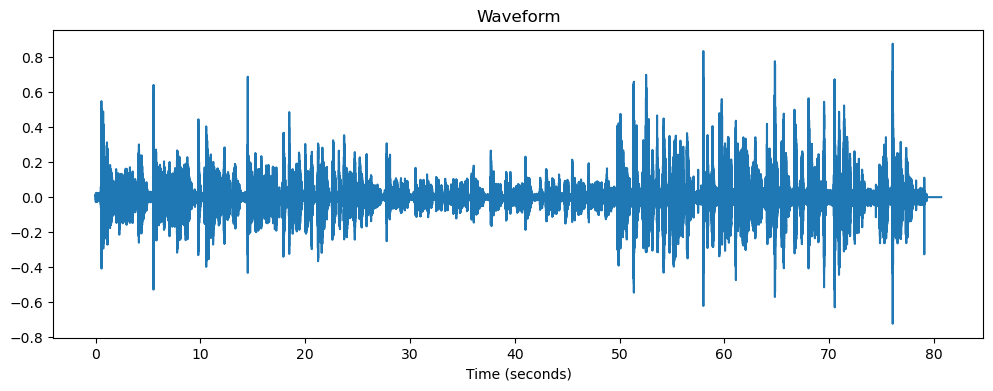

feature:zcr,average value:0.08328176761047565


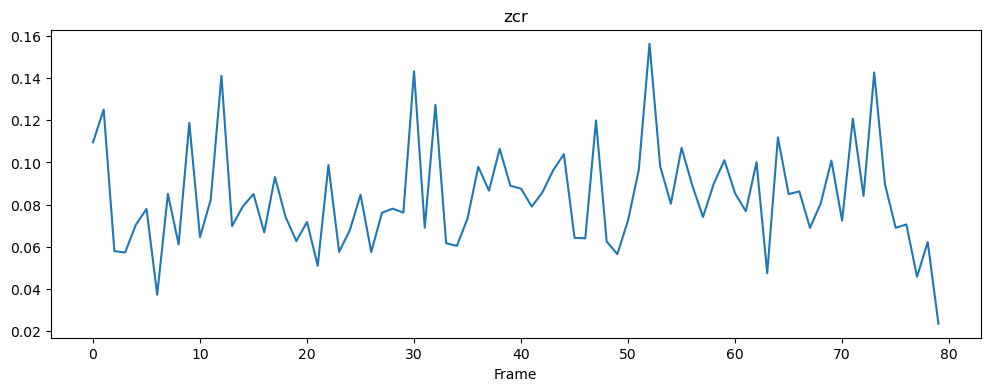

feature:energy,average value:0.003448200064109097


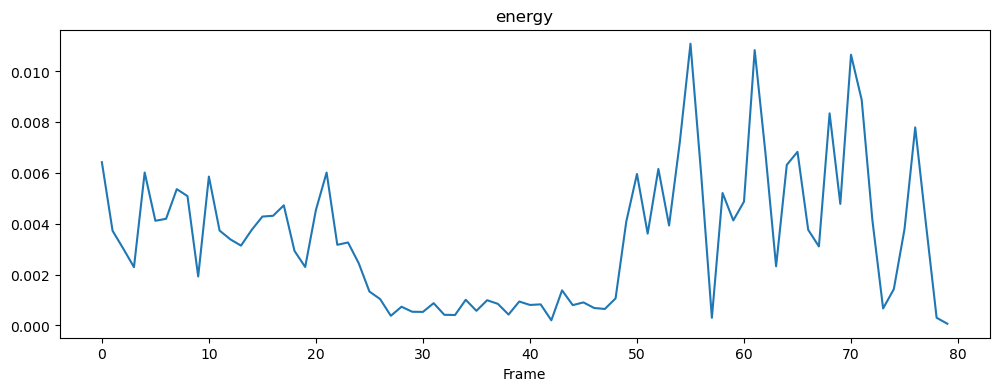

feature:energy_entropy,average value:2.5982182167421852


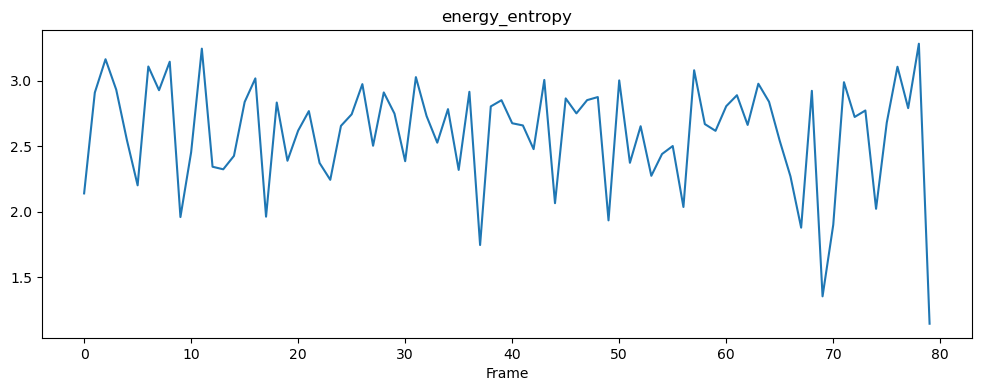

feature:spectral_centroid,average value:0.18550737576206405


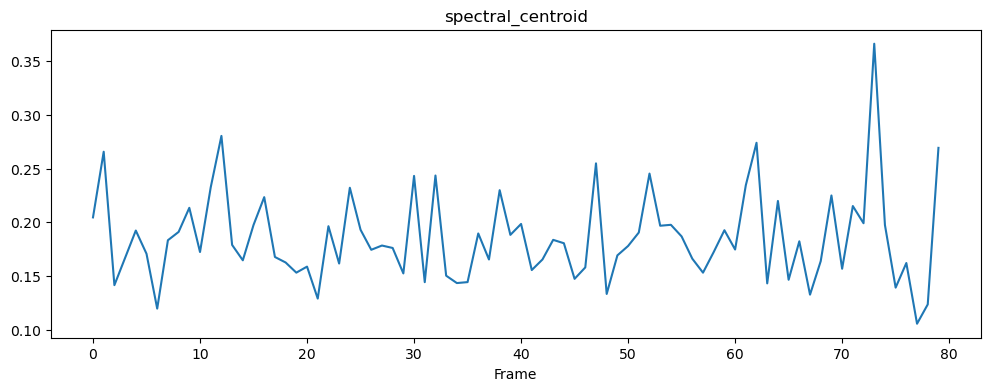

feature:spectral_spread,average value:0.2029478830296217


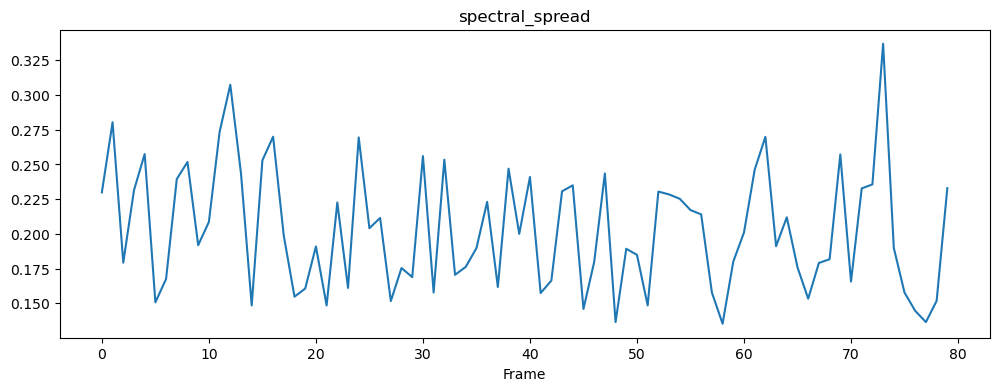

feature:spectral_entropy,average value:0.7086989553558587


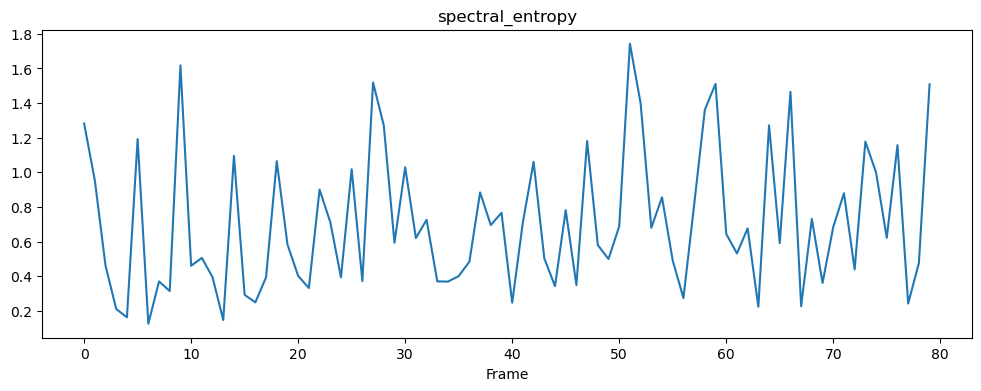

feature:spectral_flux,average value:0.0009304916794140082


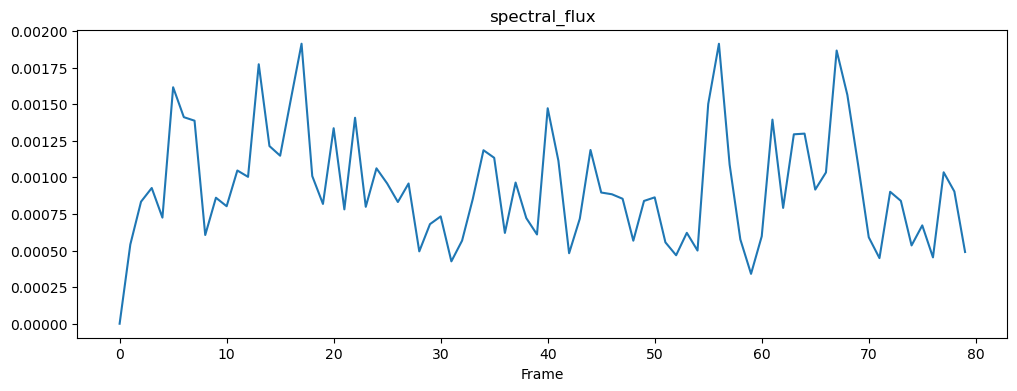

feature:spectral_rolloff,average value:0.1329078125


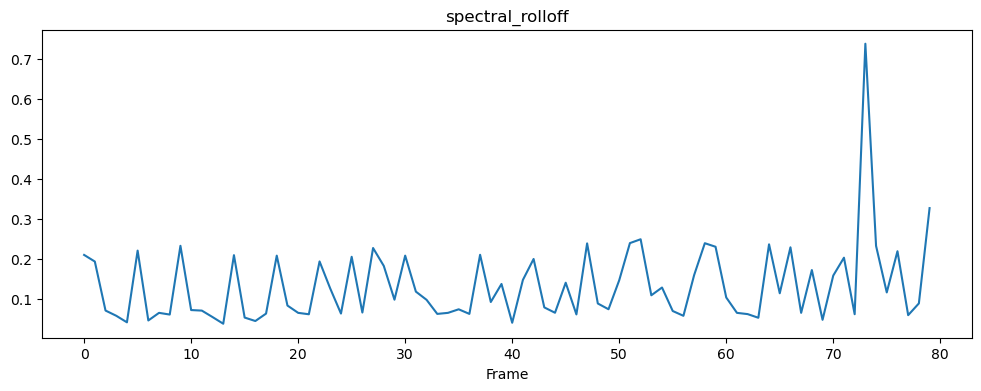

feature:mfcc_1,average value:-22.41912225767421


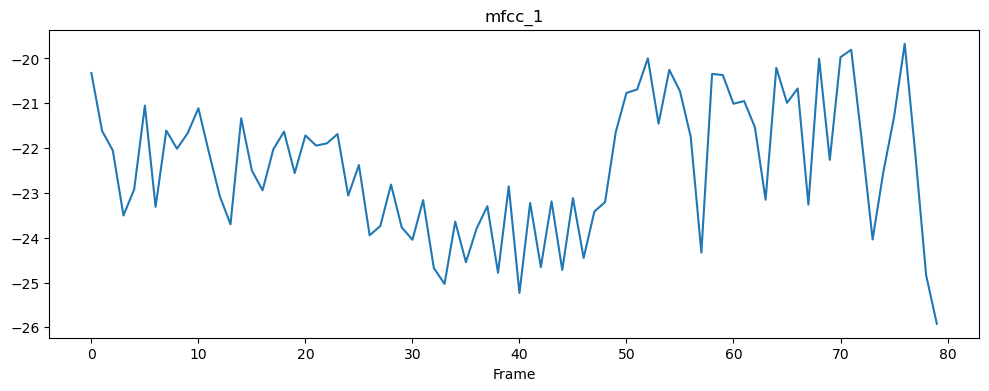

feature:mfcc_2,average value:2.2332738110270194


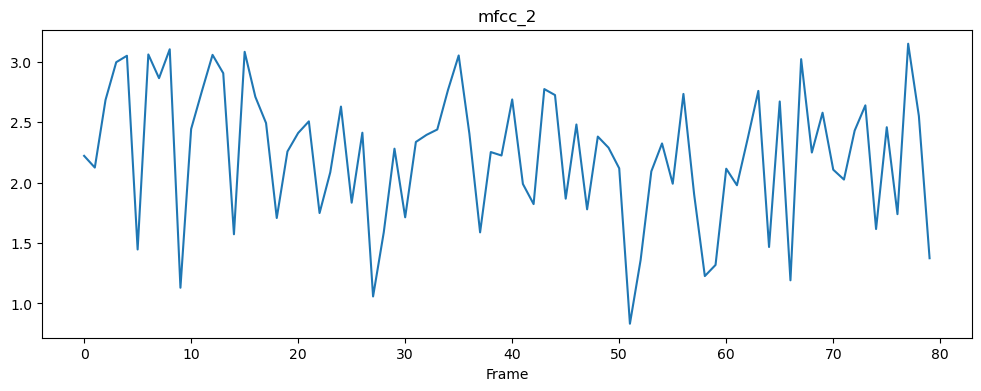

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from pyAudioAnalysis import audioBasicIO, ShortTermFeatures

# Load audio file
audio_file = "output_audio.wav"

# Extract features using pyAudioAnalysiss, fs = librosa.load(audio_file, sr = 16000)
s, Fs = librosa.load(audio_file, sr = 16000)
'''frame_size = 2048
hop_length = 512

# Calculate autocorrelation for each frame
autocorr = librosa.autocorrelate(s, max_size=frame_size)

# Find peaks in autocorrelation
peaks = librosa.util.peak_pick(autocorr, pre_max=10, post_max=10, pre_avg=10, post_avg=10, delta=0.1,wait=10)
nonzero_peaks = peaks[peaks>0]
# Convert lag to frequency (F0)
f0_hz = Fs / nonzero_peaks.astype(float)'''



F, f_names = ShortTermFeatures.feature_extraction(s, Fs,Fs,Fs)

time_axis = np.arange(0, len(s)) / Fs  # Time axis in seconds
plt.figure(figsize=(12, 4))
plt.plot(time_axis, s)
plt.title('Waveform')
plt.xlabel('Time (seconds)')
#plt.ylabel('Amplitude')
plt.show()

'''plt.figure(figsize=(12, 4))
plt.plot(F[0, :])
plt.title('ZCR Contour')
plt.xlabel('Frame')
plt.ylabel('')
plt.show()

# Plot pitch contour
plt.figure(figsize=(12, 4))
plt.plot(F[1, :])
plt.title('Pitch Contour')
plt.xlabel('Frame')
plt.ylabel('Pitch')
plt.show()'''

for i in range(10):
    print(f"feature:{f_names[i]},average value:{np.mean(F[i, :])}")
    plt.figure(figsize=(12, 4))
    plt.plot(F[i, :])
    plt.title(f_names[i])
    plt.xlabel('Frame')
    #plt.ylabel(f_names[i])
    plt.show()


In [48]:
for i in range(10):
    print(f"feature:{f_names[i]},average value:{np.mean(F[i, :])}")

feature:zcr,average value:0.08328176761047565
feature:energy,average value:0.003448200064109097
feature:energy_entropy,average value:2.5982182167421852
feature:spectral_centroid,average value:0.18550737576206405
feature:spectral_spread,average value:0.2029478830296217
feature:spectral_entropy,average value:0.7086989553558587
feature:spectral_flux,average value:0.0009304916794140082
feature:spectral_rolloff,average value:0.1329078125
feature:mfcc_1,average value:-22.41912225767421
feature:mfcc_2,average value:2.2332738110270194


In [56]:
import cv2
import numpy as np
import time
# Function to calculate image contrast for a frame
'''def calculate_contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_norm = hist / hist.sum()
    contrast = np.sum((hist_norm * np.arange(256))**2)
    return contrast'''
def calculate_contrast(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contrast = np.std(gray)
    return contrast

# Function to calculate image brightness (mean intensity) for a frame
def calculate_brightness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

# Function to calculate image colorfulness for a frame
def calculate_colorfulness(image):
    (B, G, R) = cv2.split(image.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)
    (rb_mean, rb_std) = (np.mean(rg), np.std(rg))
    (yb_mean, yb_std) = (np.mean(yb), np.std(yb))
    std_root = np.sqrt((rb_std ** 2) + (yb_std ** 2))
    mean_root = np.sqrt((rb_mean ** 2) + (yb_mean ** 2))
    colorfulness = std_root + (0.3 * mean_root)
    return colorfulness

# Function to calculate image blurriness for a frame
def calculate_blurriness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var

# Function to calculate image sharpness for a frame
def calculate_sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    edge_img = np.sqrt(sobelx**2 + sobely**2)
    return np.mean(edge_img)

# Function to process video and extract features for all frames
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    wait_time = int(1000 / fps*2)
    contrast_values = []
    brightness_values = []
    colorfulness_values = []
    blurriness_values = []
    sharpness_values = []
    prev_time = time.time()
    frame_c=0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        current_time = time.time()
        elapsed_time = current_time - prev_time
        
        f=" "
        if elapsed_time >= 1.0: 
            prev_time =current_time # Process frame once per second
            frame_c+=1
            f+="-"
            print(f,end=" ")
            prev_time = current_time
            # Calculate features for each frame
            contrast = calculate_contrast(frame)
            brightness = calculate_brightness(frame)
            colorfulness = calculate_colorfulness(frame)
            blurriness = calculate_blurriness(frame)
            sharpness = calculate_sharpness(frame)
            #plt.imshow(frame)
            #plt.show()

            # Store feature values for each frame
            contrast_values.append(contrast)
            brightness_values.append(brightness)
            colorfulness_values.append(colorfulness)
            blurriness_values.append(blurriness)
            sharpness_values.append(sharpness)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break

    # Release video capture object
    cap.release()
    def normalize(arr):
        f=np.mean(arr)
        min_=np.min(arr)
        max_=np.max(arr)
        normalized_value = (f - min_) / (max_ - min_)
        return normalized_value

    # Compute average values
    avg_contrast = normalize(contrast_values)
    avg_brightness =normalize(brightness_values)
    avg_colorfulness = normalize(colorfulness_values)
    avg_blurriness = normalize(blurriness_values)
    avg_sharpness = normalize(sharpness_values)

    return fps, frame_count, width, height, avg_contrast, avg_brightness, avg_colorfulness, avg_blurriness, avg_sharpness

# Example usage
video_file = 'sample_video.mp4'
fps, frame_count, width, height, avg_contrast, avg_brightness, avg_colorfulness, avg_blurriness, avg_sharpness = process_video("tryvideo.mp4")

def normalize(f):
    min_=np.min(f)
    max_=np.max(f)
    normalized_value = (f - min_) / (max_ - min_)
    return normalized_value
print(f"Frame Rate: {fps} fps")
print(f"Frame Count: {frame_count}")
print(f"Frame Dimensions: {width}x{height}")
print(f"Average Contrast: {(avg_contrast)}")
print(f"Average Brightness: {(avg_brightness)}")
print(f"Average Colorfulness: {(avg_colorfulness)}")
print(f"Average Blurriness: {(avg_blurriness)}")
print(f"Average Sharpness: {(avg_sharpness)}")


 -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - Frame Rate: 23.976024627685547 fps
Frame Count: 515
Frame Dimensions: 1920x1080
Average Contrast: 0.35315393682522855
Average Brightness: 0.4532276325213535
Average Colorfulness: 0.6419939318329704
Average Blurriness: 0.35310266951207214
Average Sharpness: 0.39995299663649725


In [68]:
from moviepy.editor import VideoFileClip

def extract_audio(video_path, audio_path):
    video = VideoFileClip(video_path)
    audio = video.audio
    audio.write_audiofile(audio_path)
    audio.close()
    video.close()

# Example usage
extract_audio("videoreume.mov", "output_audio.wav")
import speech_recognition as sr

def recognize_speech(audio_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as source:
        audio_data = recognizer.record(source)
        text = recognizer.recognize_google(audio_data)
        return text

# Example usage
recognized_text = recognize_speech("output_audio.wav")
print("Recognized Speech:", recognized_text)
print("aaaa")
def analyze_speech_clarity(audio_path):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_path) as audio_file:
        audio_data = recognizer.record(audio_file)
        try:
            text = recognizer.recognize_google(audio_data)
            print("Speech recognized:", text)
        except sr.UnknownValueError:
            print("Speech could not be recognized.")
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))
    


MoviePy - Writing audio in output_audio.wav


MoviePy - Done.
Recognized Speech: hi myself as Kumar Singh and thank you for providing me the opportunity to introduce myself I am currently doing BTech in data Science from Heritage Institute of Technology and I am very much passionate about becoming a sports analyst in a new future I have done my schooling from a place called Children Day School Kalyani where I have completed 10th and my 12th with an aggregate of 9 and 8.3 respect and general knowledge olympiads which help me to get knowledge about different domains of science I am proficient in all three languages English Hindi and Bengali always enjoy the sense of teamwork and always been a team player and perform extremely well when I was in a team if I get an opportunity I am sure that my skills and knowledge is going to be the Asset to your project and ideas lineup which I am eagerly waiting to share with your team I am very excited to work with you and talented group of students thank you for your time and I am looking forward

In [71]:
from language_tool_python import LanguageTool
def check(list):
    tool = LanguageTool('en-US')  # 'en-US' for English language
    for i in list:
    # Text to check for grammatical errors
        text = i

        # Check for grammatical errors
        matches = tool.check(text)

        # Print and correct errors
        if len(matches) > 0:
            print(f"Found {len(matches)} grammatical error(s):")
            for match in matches:
                if match.ruleId!=UPPERCASE_SENTENCE_START:
                    print(f"{match.ruleId}: {match.message} --> Suggested correction: {match.replacements}")
        else:
            print("No grammatical errors found.")
check()

No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical errors found.
No grammatical

KeyboardInterrupt: 

In [67]:
text="The sports and entertainment industry thrives on fan engagement, which is an essential component of its success. A strong and dedicated fan base not only generates revenue through ticket sales and merchandise but also adds value to the brand. However, with the proliferation of digital technology, fans now have an array of options and distractions at their disposal. Therefore, it has become imperative for organizations to utilize data and analytics to understand fan behavior and preferences. This is where fan engagement analytics comes in. By analyzing data and deriving actionable insights, organizations can create targeted strategies to enhance fan engagement and deliver unforgettable experiences that will keep fans coming back for more.Fan engagement analytics offers significant advantages to sports organizations. It allows them to gain a complete and thorough understanding of their fan behavior by analyzing data from various sources such as social media, ticket sales, and website interactions. The analysis of this information provides valuable insights into fan preferences, interests, and engagement levels, which can be used to tailor marketing efforts and communication strategies to best meet the specific needs and expectations of the fan base. This data-driven approach helps organizations to create a personalized fan experience and build a deeper connection with fans. Overall, fan engagement analytics is a powerful tool that enables organizations to improve fan engagement and satisfaction, leading to increased loyalty and revenue.Organizations can increase fan satisfaction and brand loyalty by understanding the demographics, interests, and behaviors of their fans. By doing so, they can deliver personalized content, offers, and experiences that make fans feel valued and appreciated. This level of customization not only enhances the likelihood of repeat engagement but also increases the chances of developing a long-term relationship with the fans.Fan engagement analytics can help optimize the game-day experience and increase fan satisfaction. By analyzing concession sales and social media feedback, organizations can identify popular choices and quickly address concerns to demonstrate their commitment to fan satisfaction. These insights can also help improve marketing campaigns, merchandise sales, and overall fan experience, leading to increased loyalty and revenue.Fan engagement analytics is a powerful tool to monitor and analyze social media conversations and sentiment. This data can be used to develop effective social media strategies, create compelling content, and engage in meaningful conversations with fans. Overall, it's a crucial component of any organization's social media strategy that provides valuable insights into fan behavior and preferences.Fan engagement analytics helps organizations justify investments in fan engagement initiatives. By tracking KPIs such as ticket sales, merchandise revenue, social media engagement, and fan satisfaction scores, organizations can assess the impact of their fan engagement strategies and make data-driven decisions for future initiatives.The Seattle Seahawks, a professional football team in the NFL, utilized data science techniques to enhance fan engagement and improve the stadium experience for their loyal supporters. The team gathered data from different sources, including ticketing systems, social media platforms, and in-stadium surveys. By analyzing this data, the Seahawks obtained insights into fan preferences, attendance patterns, and purchasing behavior. They utilized this information to personalize ticket pricing based on demand, offer targeted promotions and discounts, and enhance stadium operations.In the Indian Premier League (IPL), ESPNcricinfo uses Smart Stats during matches. Smart Stats offers insightful metrics and visualizations, such as the Expected Runs (ER) metric. This metric calculates a batsman's expected contribution to the game based on factors like runs scored, balls faced, and match context. During a high-scoring match, Smart Stats can reveal how a batsman's performance exceeds expectations. This provides fans with a deeper appreciation of their impact on the game beyond traditional statistics.of the noteworthy things in the English Premier League (EPL) is Manchester City's use of data-driven content on social media. The club employs advanced analytics to understand fan preferences and trends, which helps them create highly engaging content that resonates with their audience. For example, Manchester City may create visually stunning graphics highlighting key moments from a thrilling match, supported by insightful statistics and analysis. This approach captivates fans on social media, and reinforces Manchester City's reputation as a forward-thinking club that prioritizes fan engagement strategies.Kinexon Sport technology is being used by many famous sports teams and organizations across various sports, such as FC Bayern Munich, Dallas Mavericks (Basketball), and Red Bull Racing (Formula 1). Kinexon Sport utilizes ultra-wideband technology to track athletes' movements in real-time accurately. Though it is primarily used for optimizing team performance, it can also enhance fan engagement. Fans can benefit from live player tracking, interactive visualizations, augmented reality experiences, and engaging challenges based on the data collected. Overall, Kinexon Sport revolutionizes fan engagement by providing deeper insights and interactive experiences during live sporting events.Fan engagement analytics is a powerful tool that can help organizations in the sports and entertainment industry to increase fan engagement and create unforgettable experiences. By utilizing data and analytics, organizations can gain valuable insights into fan behavior, personalize their marketing efforts, improve the game-day experience, leverage social media platforms, and measure the ROI of their fan engagement initiatives.By adopting a data-driven approach, organizations can build a strong and dedicated fan base that generates revenue and enhances brand value. So, if you're looking to excel in the sports and entertainment industry, harnessing the power of fan engagement analytics should be your top priority."
import textrazor

textrazor.api_key = "a2ee0328e56b8d53adf8c26f1791383018e8ea4ca9c7ad67691af8f8"

client = textrazor.TextRazor(extractors=["entities"])
response = client.analyze(text)
id1=[]
rs=[]
cs=[]
ft=[]
for entity in response.entities():
    print(entity.id,"//",entity.relevance_score,"//",entity.confidence_score,"//",entity.wikipedia_link)
    id1.append(entity.id)
    rs.append(entity.relevance_score)
    cs.append(entity.confidence_score)
    ft.append(entity.wikipedia_link)

    

Revenue // 0.2262 // 3.158 // http://en.wikipedia.org/wiki/Revenue
Sales // 0.5571 // 1.304 // http://en.wikipedia.org/wiki/Sales
Brand // 0.7594 // 6.496 // http://en.wikipedia.org/wiki/Brand
Technology // 0.3669 // 6.925 // http://en.wikipedia.org/wiki/Technology
Organization // 0.3883 // 1.276 // http://en.wikipedia.org/wiki/Organization
Data // 0.4983 // 1.481 // http://en.wikipedia.org/wiki/Data
Analytics // 1 // 3.944 // http://en.wikipedia.org/wiki/Analytics
Data analysis // 0.7014 // 1.406 // http://en.wikipedia.org/wiki/Data_analysis
Data // 0.4983 // 1.892 // http://en.wikipedia.org/wiki/Data
Organization // 0.3883 // 1.298 // http://en.wikipedia.org/wiki/Organization
Data // 0.5351 // 1.33 // http://en.wikipedia.org/wiki/Data
Social media // 0.6182 // 9.933 // http://en.wikipedia.org/wiki/Social_media
Digital marketing // 0.7523 // 1.333 // http://en.wikipedia.org/wiki/Digital_marketing
Seattle Seahawks // 0.2524 // 15.19 // http://en.wikipedia.org/wiki/Seattle_Seahawks
Asso

In [72]:
import nltk
from nrclex import NRCLex
text="hi myself as Kumar Singh and thank you for providing me the opportunity to introduce myself I am currently doing BTech in data Science from Heritage Institute of Technology and I am very much passionate about becoming a sports analyst in a new future I have done my schooling from a place called Children Day School Kalyani where I have completed 10th and my 12th with an aggregate of 9 and 8.3 respect and general knowledge olympiads which help me to get knowledge about different domains of science I am proficient in all three languages English Hindi and Bengali always enjoy the sense of teamwork and always been a team player and perform extremely well when I was in a team if I get an opportunity I am sure that my skills and knowledge is going to be the Asset to your project and ideas lineup which I am eagerly waiting to share with your team I am very excited to work with you and talented group of students thank you for your time and I am looking forward to hear from you"
emotion=NRCLex(text)
emotion.raw_emotion_scores

{'anticipation': 10,
 'joy': 6,
 'positive': 16,
 'trust': 12,
 'negative': 1,
 'surprise': 1}